## Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm, linregress
import sklearn
# from importlib import reload

### define project paths

In [2]:
## relative root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '3_relate_drawing_training_and_recog_prepost.ipynb'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import analysis_helpers as h
reload(h)
h.data_dir = data_dir
h.path_to_recog = os.path.join(data_dir, 'features/recog')
h.path_to_draw = os.path.join(data_dir, 'features/drawing')
h.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
h.roi_list_recog = np.array(['V1', 'V2', 'LOC', 'fusiform','parahippo','IT','ento','PRC','hipp','mOFC'])
roi_list_recog = h.roi_list_recog

### relate individual differences in overall target selectivity (log odds of target vs. foil) to prepost differentiation

This plots the raw correlations between classifer evidence for target - foil, and prepost differentiation between trained objects

In [3]:
# set 
version = '4way'
tag = 'log'
d = pd.read_csv(os.path.join(proj_dir,'csv/difference_{}probs_{}.csv'.format(tag,version)))
prepost = pd.read_csv(os.path.join(proj_dir,'csv/neural_changes_by_surfroi_and_subject.csv'))

In [14]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']
roi_labels = ['V1', 'V2', 'LOC', 'IT', 'Fus', 'PHC', 'PRC', 'EC','HC', 'mOFC', 
              'V1', 'V2', 'LOC', 'IT', 'Fus', 'PHC', 'PRC', 'EC','HC', 'mOFC']

draws, recogs = [], []
for anchoring in ['Unanchored','Anchored']:
    print '===== {} ===== '.format(anchoring)
    for this_roi in roi_list:
        draw = d[d['roi']==this_roi]['target-foil'].values
        recog = (prepost['{}TrainedDiff_{}'.format(anchoring, this_roi)].values-
                 prepost['{}ControlDiff_{}'.format(anchoring, this_roi)].values)

        draws = np.array(draw) if len(draws)==0 else np.vstack((draws, np.array(draw)))
        recogs = np.array(recog) if len(recogs)==0 else np.vstack((recogs, np.array(recog)))

        z = pd.DataFrame([draw,recog])
        z = z.transpose()
        z.columns=['draw','recog']

        ## plot 
        fig = plt.figure(figsize=(6,6))
        sns.set_context('poster')
        sns.regplot(x="draw",
                    y ="recog",
                    data=z)
        r,p = stats.pearsonr(draw,recog)
        plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
        if np.round(p,5)<0.05:
            accent = '*'
        else:
            accent = ''
        print('ROI: {}  r = {}  p = {} {}'.format(this_roi,np.round(r,5),np.round(p,5),accent))
        plt.xlabel('drawing: target vs. foil contrast') 
        plt.ylabel('recog: post-pre differentiation')
        if not os.path.exists(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name))):
            os.makedirs(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name)))
        plt.tight_layout()
        plt.savefig(os.path.join(proj_dir,'plots/{}/drawrecog/draw_recog_scatter_{}.pdf'.format(nb_name,this_roi)))
        plt.close(fig)

===== Unanchored ===== 
ROI: V1  r = 0.42982  p = 0.01581 *
ROI: V2  r = 0.47903  p = 0.0064 *
ROI: LOC  r = 0.06962  p = 0.70977 
ROI: IT  r = -0.17191  p = 0.35511 
ROI: fusiform  r = -0.44918  p = 0.01125 *
ROI: parahippo  r = 0.25285  p = 0.16994 
ROI: PRC  r = -0.21849  p = 0.23766 
ROI: ento  r = 0.13688  p = 0.46278 
ROI: hipp  r = -0.04815  p = 0.79701 
ROI: mOFC  r = -0.48789  p = 0.00537 *
===== Anchored ===== 
ROI: V1  r = 0.20916  p = 0.25879 
ROI: V2  r = 0.17925  p = 0.33463 
ROI: LOC  r = -0.13274  p = 0.47657 
ROI: IT  r = -0.30805  p = 0.0918 
ROI: fusiform  r = -0.5505  p = 0.00133 *
ROI: parahippo  r = 0.25872  p = 0.15992 
ROI: PRC  r = -0.29273  p = 0.11003 
ROI: ento  r = -0.04645  p = 0.80402 
ROI: hipp  r = 0.20295  p = 0.27352 
ROI: mOFC  r = -0.29982  p = 0.10128 


This plots correlations across phase and roi.

For example, does foil inhibition in one roi predict differentiation in another

In [7]:
# Do you want to (roughly) exclude non significant correlations in plot?
exclude_ns = True

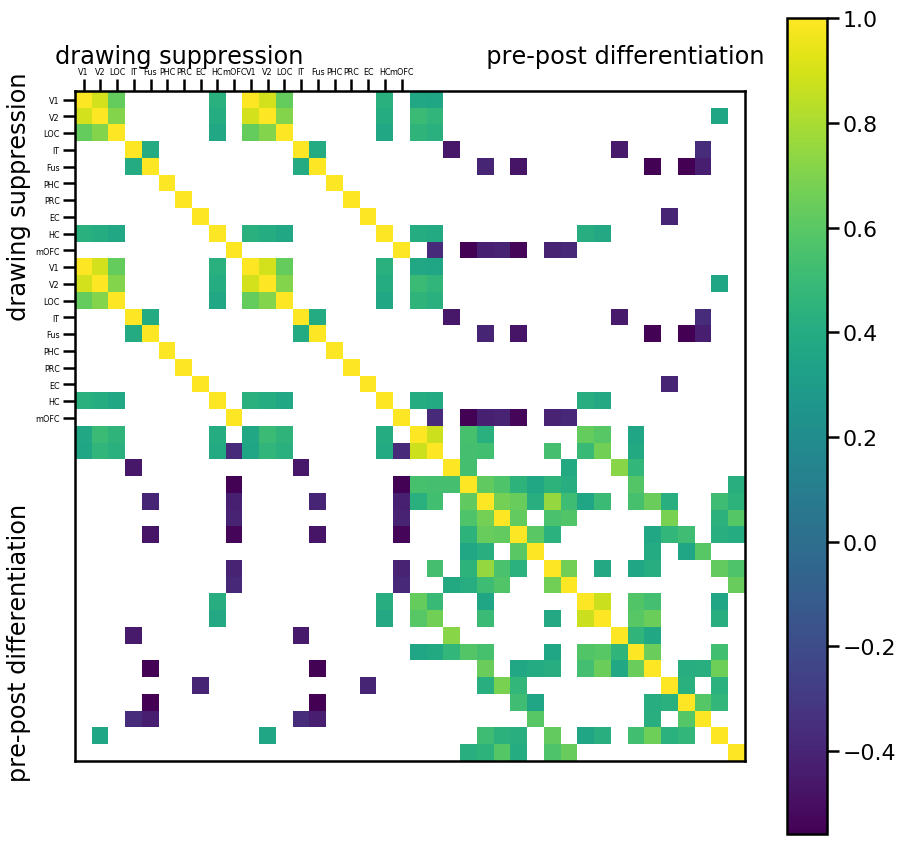

In [8]:
altogether = np.vstack((draws,recogs))
corrs = np.corrcoef(altogether)
derp = (corrs > -0.36) & (corrs < 0.36)
corrs2 = np.copy(corrs)
if exclude_ns:
    np.place(corrs2, derp, np.nan)
    fig, ax = plt.subplots(figsize=(15,15))
im = ax.matshow(corrs2)
ax.set_xticks(np.arange(len(roi_labels)))
ax.set_xticklabels(roi_labels, fontsize=8)
ax.set_yticks(np.arange(len(roi_labels)))
ax.set_yticklabels(roi_labels, fontsize=8)
ax.set_ylabel('pre-post differentiation                        drawing suppression')
ax.set_xlabel('drawing suppression                        pre-post differentiation')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
plt.colorbar(im)
plt.show()

### Some observations:
* ROIs where we see positive relationship are: *V1*, *V2*. That is, individuals with GREATER target selectivity during drawing in these regions also show GREATER prepost differentiation.
* ROIs where we see negative relationship are: *fusiform*, *mOFC* (maybe PRC?) That is, individuals with LESS target selectivity during drawing in these regions also show GREATER prepost differentiation.

### When does the relationship between target selectivity and differentiation emerge in these ROIs?


In [9]:
# Set initial parameters
version = '4way'
logged = True
tag = 'logged' if logged else 'raw'
ALLDM = pd.read_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)))
ALLDM = h.cleanup_df(ALLDM)

roi_list = roi_list_recog
subs = np.unique(ALLDM.subj.values)
ivs = ['trial_num'] # ['run_num','trial_num','time_point']
takeDiffDifference = True ## compare trained object differentiation vs. control object differentiation?

In [10]:
for anchored in [True, False]:
    specs = ('anchored' if anchored else 'unanchored', 'logged' if logged else 'raw')
    for this_iv in ivs:
        for this_roi in roi_list:
            # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
            # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
            scores = []
            for sub in subs:
                inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                t,f,c = h.get_prob_timecourse(this_iv,ALLDM[inds],version=version)

                if len(scores)==0:
                    scores = t-f
                else:
                    scores = np.vstack((scores,t-f))

            # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
            # in the same order as they are in the matrix.
            if anchored:
                recog = prepost['AnchoredTrainedDiff_{}'.format(this_roi)].values
                recog -= prepost['AnchoredControlDiff_{}'.format(this_roi)].values if takeDiffDifference else 0
            else:
                recog = prepost['UnanchoredTrainedDiff_{}'.format(this_roi)].values
                recog -= prepost['UnanchoredControlDiff_{}'.format(this_roi)].values if takeDiffDifference else 0 

            # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
            # and the prepost change vector is the time course we're looking to understand for this ROI.
            if this_roi == 'Frontal':
                ## SEE HERE: lets decide what to do with classifier output == 0 in rare cases, ignore missing? 
                ## or add 1e-6 or smallest number in dataset so we can avoid having this catch here
                trial_corrs = [pd.DataFrame([scores[:,i], recog]).transpose().corr()[0][1] for i in range(np.shape(scores)[1])]
            else:
                trial_corrs = [stats.pearsonr(scores[:,i],recog)[0] for i in range(np.shape(scores)[1])]

            bootstrap = [h.corrbootstrapCI(scores[:,i], recog, 1000) for i in range(np.shape(scores)[1])]
            lower_bound, upper_bound = [b[1] for b in bootstrap], [b[2] for b in bootstrap]                 
            
            fig, ax = plt.subplots(figsize=(8,4))
            ax.plot(trial_corrs, 'ro', label='data')
            plt.axhline(y=0.0,linestyle='dashed')
            plt.ylim((-1,1))
            plt.ylabel('Correlation (t-c / prepost)')
            plt.xlabel(this_iv)
            plt.title('ROI: {}'.format(this_roi))
            plt.fill_between(np.arange(len(trial_corrs)), lower_bound, upper_bound, alpha=.2)
        
            if not os.path.exists(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name))):
                os.makedirs(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name)))
            plt.tight_layout()
            plt.savefig(os.path.join(proj_dir,'plots/{}/drawrecog/trial_corrs_{}_{}_{}.pdf'.format(nb_name, this_roi, *specs)))
            plt.close(fig)
            

### Create summary barplot of either mean correlation across subjects, or mean slope.

Choose any number of possible plots

NOTE: the full set of plots for 'mean' will create 32 plots and take ages.

In [12]:
# read in data and set some initial parameters

ALLDM = pd.read_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,'logged' if logged else 'raw')))
prepost = pd.read_csv(os.path.join(str(results_dir),'neural_changes_by_surfroi_and_subject.csv'))


takeDiffDifference = True

# Choose what measure to plot
plotting = 'mean' # ['mean', 'slope']

# choose which unit of time to iterate over
ivlist = ['run_num'] # ['run_num', 'trial_num', 'time_point']

# Choose whether to log or not
loglist = [True] # [True, False]

# Choose whether anchored or unanchored RSA
anchorlist = [False] # [True, False]

# Choose the critical measure for classifier output
measurelist = ['t-f'] # ['t','f','t-f','txf']

# ROI list
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC'])


units_dict = {'run_num': 4, 'trial_num': 20, 'time_point': 23}


In [13]:
# Run through the plots, based on parameters above

for this_iv in ivlist:
    units = units_dict[this_iv]
    for logged in loglist:
        for anchored in anchorlist:
            for clfmeasure in measurelist:
                print('logged: {}; anchored: {}; clf: {}; iv: {}'.format(logged, anchored, clfmeasure, this_iv))
                specs = ('anchored' if anchored else 'unanchored', 'logged' if logged else 'raw')
                subs = np.unique(ALLDM.subj.values)

                columns = []
                for this_roi in roi_list:
                    _scores = np.array([h.get_prob_timecourse(this_iv,ALLDM[(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)]) for sub in subs])
                    scores = [h.compute_clf_measure(_scores[i,0,:], _scores[i,1,:], clfmeasure) for i in range(_scores.shape[0])]

                    objs = [str(np.unique(ALLDM[(ALLDM['subj']==sub)].label.values)) for sub in subs]
                    if anchored:
                        recog = prepost['AnchoredTrainedDiff_{}'.format(this_roi)].values
                        recog -= prepost['AnchoredControlDiff_{}'.format(this_roi)].values if takeDiffDifference else 0
                        print(recog)
                    else:
                        recog = prepost['UnanchoredTrainedDiff_{}'.format(this_roi)].values
                        recog -= prepost['UnanchoredControlDiff_{}'.format(this_roi)].values if takeDiffDifference else 0

                    columns.append([{'clf':scores[i], 'diff':recog[i], 'objs':objs[i]} for i in range(len(scores))])
                bardf = pd.DataFrame(columns).transpose()
                bardf.columns = roi_list

                if plotting == 'mean':

                    # derive from bardf the df we want to plot and the error bars we want
                    meandf = pd.DataFrame([h.scoreVSdiff(np.array(bardf)[:,i], roi_list[i]) for i in range(len(roi_list))]).transpose()
                    meandf.columns = roi_list
                    error = [h.custom_bootstrapCI(np.array(bardf)[:,i], h.scoreVSdiff, 1000, roi_list[i])[1:3] for i in range(len(roi_list))]
                    title = 'Subjectwise Relationship B/t Mean({}) & PrePost Diff'.format(clfmeasure)
                    ylab = 'Average Correlation'
                    outfig = 'mean_{}_{}_{}_{}.png'.format(this_iv, clfmeasure, *specs)

                else:

                    # derive from bardf the df we want to plot and the error bars we want
                    meandf = pd.DataFrame([h.slope_scoreVSdiff(np.array(bardf)[:,i], roi_list[i], units) for i in range(len(roi_list))]).transpose()
                    meandf.columns = roi_list
                    error = [h.custom_bootstrapCI(np.array(bardf)[:,i], h.slope_scoreVSdiff, 1000, roi_list[i], units)[1:3] for i in range(len(roi_list))]
                    title = 'Slope over Timepoints of Subjectwise Relationship B/t {} & Prepost Diff'.format(clfmeasure)
                    ylab = 'Average Slope'
                    outfig = 'slope_{}_{}_{}_{}.png'.format(this_iv, clfmeasure, *specs)

                fig = plt.figure(figsize=(17,6))
                sns.barplot(data=meandf,palette='husl',ci=None)
                plt.xlabel('ROIs')
                plt.title(title) 
                plt.ylabel(ylab) 
                for i in range(len(roi_list)):
                    plt.vlines(i, error[i][0], error[i][1])
                plt.tight_layout()
                if not os.path.exists(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name))):
                    os.makedirs(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name)))
                plt.tight_layout()
                plt.savefig(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name), outfig))
                plt.close(fig)

logged: True; anchored: False; clf: t-f; iv: run_num
